# Introduction: Quantamental Trading.

### In this notebook, we have developed a Trading Strategy by using the Fundamental data and some Quant Techniques. Notebook is divided in two parts, One the Strategy Formulation and another, the Backtesting

#### Importing the relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import ankitfinance as af
from scipy.stats import norm
import scipy.stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import yfinance as yf
from datetime import date
import seaborn as sb
import monthly_returns_heatmap as mrh
import FundamentalAnalysis as fa
import seaborn as sb
sb.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')


# Strategy Formulation

## Doing Analysis on Group of Companies taking latest Ratios  "Inter-Company".

#### We will do the inter-company Analysis, to find the relatively undervalued companies among its peers, for this will be using the Z-score methode to calculate the Scores of the Companies and Ranking them accordingly.

In [2]:
tickers=["GILD",'MU','AMAT','MSFT','AMD','CSCO','QCOM','GOOG','TSLA','TXN','INTC','ATVI','PEP','PCAR']
# Using Top Nasdaq  Stocks : 
ratio=['peRatio','pbRatio','evToSales','debtToEquity','debtToAssets','netDebtToEBITDA']
# Ratios where the denominator must be high, to derive the value
f=pd.DataFrame()
for steps in range(len(tickers)):
    p=str(tickers[steps])
    data=fa.key_metrics(ticker=p,api_key='---------------------',period='quarter')
    table=data.T[ratio]
    f_1=table.head(1)
    f=f.append(f_1)

f.index=tickers
inverse=1/f # So, as to derive the Value Metrics out of the algorithm "Inter Company Analysis"

inverse # Inverse Matrix Consist of the Ratios that must be maximised as we have already taken the Reciprocal.

,peRatio,pbRatio,evToSales,debtToEquity,debtToAssets,netDebtToEBITDA
GILD,0.0848511,0.248946,0.0753238,0.635434,1.36307,0.123676
MU,0.0252891,0.426339,0.0651645,6.45649,4.01833,9.51765
AMAT,0.0488083,0.123889,0.0558397,2.10552,1.96966,-9.32317
MSFT,0.0368083,0.0775038,0.0249503,2.36209,1.74891,0.4482
AMD,0.0633846,0.0519337,0.0291915,17.6879,2.86784,-0.0719423
CSCO,0.0538443,0.20692,0.0640172,4.09472,1.69265,-1.73872
QCOM,0.0586139,0.0440499,0.0455188,0.484538,1.24519,0.216042
GOOG,0.0514626,0.188033,0.048589,15.9736,3.29257,-1.546
TSLA,0.00145203,0.0337566,0.0165103,2.31342,1.79369,-0.15605
TXN,0.044764,0.0609074,0.0263774,1.47039,1.90388,0.569764


#### Function to calculate the Z-score of the above Dataframe. So, that we can have normalized Data and can compare the Ratios and do the Ranking.

In [3]:
"reference from S&P Value bse Factor indices"

# Zscore testing to compare the company with its Peers


def zscore2(data_frame,headline='Z-Score'):
    index=data_frame.index
    z=scipy.stats.zscore(data_frame.astype(float))
    table=pd.DataFrame(z,index=index)
    mean=table.mean(axis=1)
    table2=pd.DataFrame(mean,index=index)
    condition1=np.where(table2==0,1,table2)
    condition2=np.where(condition1>0,1+condition1,1/(1-condition1))
    final=pd.DataFrame(condition2,index=index)
    final.columns=[headline]
    return final



#### Calling the Function and Calculating the Relative Score of Each company.

In [4]:
z=zscore2(inverse)
z

,Z-Score
GILD,1.114790
MU,2.085923
AMAT,0.617321
MSFT,0.671496
AMD,1.348951
CSCO,0.916182
QCOM,0.679774
GOOG,1.506549
TSLA,0.549152
TXN,0.692197


#### Now, Comparing the Companies Past year performance of each company, for this will be using some critical ratios and then will be quantifying so as to convert them into a Score.

In [5]:
f_score_ratio_max=['roe','returnOnTangibleAssets','researchAndDdevelopementToRevenue','currentRatio']
#wrt to Assets and Liability
f_score_ratio_min=['averagePayables','daysOfInventoryOnHand','interestDebtPerShare']
#Ratios where change must reduce Q/Q
g_score_ratio_max=['netIncomePerShare','freeCashFlowPerShare',"shareholdersEquityPerShare",'cashPerShare','bookValuePerShare'] 
# wrt to Cash,Income and Book Value
columns=['F-Score-Max','F-Score-Min','G-Score']



tickers=["GILD",'MU','AMAT','MSFT','AMD','CSCO','QCOM','GOOG','TSLA','TXN','INTC','ATVI','PEP','PCAR']

#F-Score and G-Score analysis to compare the companies with its Past Quarter Performances "Intra Companies Analysis"

M=pd.DataFrame()
for steps in range(len(tickers)):
    p=str(tickers[steps])
    data=fa.key_metrics(ticker=p,api_key='---------------------------',period="quarter")
    gh=data.T
    gh=gh.iloc[:,1:]
    gh=gh.loc[::-1]
    gh=gh.loc['2019-12':]
    change=gh.pct_change()
    test=change[f_score_ratio_max].dropna()
    test1=change[f_score_ratio_min].dropna()
    test2=change[g_score_ratio_max].dropna()
    g=np.where(test>0,1,-1)
    g1=np.where(test<0,1,-1)        #Conditions to Score the past performance and create a Ranking Table for every set
    g2=np.where(test2>0,1,-1)
    array=np.array([g.sum(),g1.sum(),g2.sum()])
    df=pd.DataFrame(array)
    df=df.T
    M=M.append(df)
M.index=tickers
M.columns=columns

# Now, as we already have the Scores, we take the z-score of the final DataFrame, inorder to compare the scores with each other 
ZS=scipy.stats.zscore(M) # Comparing the Score table along with its peers 
ZS=pd.DataFrame(ZS)
ZS.index=M.index
ZS.columns=M.columns
v=pd.concat([ZS,z],axis=1)
Score_table=pd.DataFrame({"Score":v.sum(axis=1)})
y=Score_table.sort_values(by='Score',ascending=False)
y                      # Final DataFrame having the Score of Each Company.

,Score
MU,2.151750
ATVI,1.922247
AMD,1.721969
MSFT,1.658898
AMAT,1.604724
CSCO,1.596393
GOOG,1.572376
TSLA,1.536555
TXN,1.065215
INTC,0.986501


### Above Dataframe has final Score and it represents the Relatively undervalued Companies, which are also Fundamentally Strong.

# Backtesting the strategy 
Selecting the companies at start of the year and 
then taking the positions in them for the year long and 
Rebalancing the companies at start of next year.

In [6]:
tik=["GILD",'MU','AMAT','MSFT','AMD','CSCO','QCOM','GOOG','TSLA','TXN','INTC','ATVI','PEP','PCAR']


In [7]:
f_score_ratio_max=['roe','returnOnTangibleAssets','researchAndDdevelopementToRevenue','currentRatio']
#wrt to Assets and Liability
f_score_ratio_min=['averagePayables','daysOfInventoryOnHand','interestDebtPerShare']
#Ratios where change must reduce Q/Q
g_score_ratio_max=['netIncomePerShare','freeCashFlowPerShare',"shareholdersEquityPerShare",'cashPerShare','bookValuePerShare','incomeQuality'] 
# wrt to Cash,Income and Book Value
columns=['F-Score-Max','F-Score-Min','G-Score']

ratio=['peRatio','priceToSalesRatio','pbRatio','evToSales','debtToEquity','evToFreeCashFlow','debtToAssets','netDebtToEBITDA']
# Ratios to derive out the value factor


Full_table=pd.DataFrame()
year=['2016','2017','2018','2019','2020']
for steps1 in range(len(year)):
    for steps2 in range(len(tik)):
        p=str(tik[steps2])
        data=fa.key_metrics(ticker=p,api_key='df22138a2ccefd56bffffaa233eebfac',period='annual')
        table=data.T[ratio]
        table=table.loc[year[steps1]]
        Full_table=Full_table.append(table)


In [8]:
Full_table

,debtToAssets,debtToEquity,evToFreeCashFlow,evToSales,netDebtToEBITDA,pbRatio,peRatio,priceToSalesRatio
2016,0.660161,1.394928,7.152119,3.746920,0.964132,5.069725,7.092207,3.150770
2016,0.561365,0.757781,-8.846387,1.889998,1.594784,1.524841,-66.739420,1.485610
2016,0.504667,0.433005,15.481868,3.308042,-0.031877,4.973058,20.854480,3.315525
2016,0.628295,0.566454,19.868946,5.817698,1.690084,6.238996,26.740624,5.264756
2016,0.874737,3.449519,694.642308,2.113846,-0.686747,21.296514,-17.825654,2.073818
...,...,...,...,...,...,...,...,...
2020,0.525244,0.680091,28.921101,10.979659,0.519274,16.881010,27.718649,10.724420
2020,0.470655,0.418285,13.158209,3.536986,0.845521,3.021773,11.717234,3.144830
2020,0.349301,0.239742,29.797608,8.011378,-1.532376,4.641684,31.769231,8.631833
2020,0.854151,3.000595,21.570518,3.269969,3.095894,14.430600,27.059135,2.758900


In [9]:
rank=pd.DataFrame()
year=['2016','2017','2018','2019','2020']
tik=["GILD",'MU','AMAT','MSFT','AMD','CSCO','QCOM','GOOG','TSLA','TXN','INTC','ATVI','PEP','PCAR']
for steps in range(len(year)):
    y=Full_table.loc[year[steps]]
    #y.index=tik
    t_inv=1/y
    bv=zscore2(t_inv)
    bv.T
    rank=rank.append(bv)


In [10]:
name=pd.DataFrame(tik)
concated=pd.concat([name,name,name,name,name],axis=0)
concated.index=rank.index
concated.columns=['Company']
rank=pd.concat([concated,rank],axis=1)

In [11]:
rank

,Company,Z-Score
2016,GILD,1.359631
2016,MU,1.283175
2016,AMAT,0.686159
2016,MSFT,0.753754
2016,AMD,0.719257
...,...,...
2020,TXN,0.726664
2020,INTC,1.729143
2020,ATVI,0.904965
2020,PEP,0.943040


### Now Doing the Intra-Company Analysis, comparing the past performances of the companies to derive out fundamentally strong companies

In [13]:
percent_fscore_max=pd.DataFrame()
tik_test=["GILD",'MU','AMAT','MSFT','AMD','CSCO','QCOM','GOOG','TSLA','TXN','INTC','ATVI','PEP','PCAR']


# Fscore-Max Analysis
for steps in range(len(tik_test)):
    p=str(tik_test[steps])
    data3=fa.key_metrics(ticker=p,api_key='df22138a2ccefd56bffffaa233eebfac',period='annual')
    tranpose=data3.T[f_score_ratio_max]
    reverse=tranpose.loc[::-1]
    change=reverse.pct_change().dropna()
    percent_fscore_max=percent_fscore_max.append(change)       
condition=np.where(percent_fscore_max>0,1,-1)            # Condition to quantify the performance
condition=pd.DataFrame(condition)
condition.index=percent_fscore_max.index
condition.columns=percent_fscore_max.columns
condition
sum_score=condition.sum(axis=1)
sum_score=pd.DataFrame(sum_score)
sum_score.columns=['F-Score-Max']
sum_score


#Fscore-Min Analysis
percent_fscore_min=pd.DataFrame()
for steps in range(len(tik_test)):
    p_2=str(tik_test[steps])
    data4=fa.key_metrics(ticker=p_2,api_key='df22138a2ccefd56bffffaa233eebfac',period='annual')
    tranpose1=data4.T[f_score_ratio_min]
    reverse1=tranpose1.loc[::-1]
    change1=reverse1.pct_change().dropna()
    percent_fscore_min=percent_fscore_min.append(change1)
condition2=np.where(percent_fscore_min<0,1,-1)               # Condition to quantify the performance
condition2=pd.DataFrame(condition2)
condition2.index=percent_fscore_min.index
condition2.columns=percent_fscore_min.columns
condition2
sum_score2=condition2.sum(axis=1)
sum_score2=pd.DataFrame(sum_score2)
sum_score2.columns=['F-Score-Min']
sum_score2

#Gscore-Max Analysis
percent_gscore_max=pd.DataFrame()
for steps in range(len(tik_test)):
    p_3=str(tik_test[steps])
    data5=fa.key_metrics(ticker=p_3,api_key='df22138a2ccefd56bffffaa233eebfac',period='annual')
    tranpose2=data5.T[g_score_ratio_max]
    reverse2=tranpose2.loc[::-1]
    change2=reverse2.pct_change().dropna()
    percent_gscore_max=percent_gscore_max.append(change2)
condition3=np.where(percent_gscore_max>0,1,-1)                # Condition to quantify the performance
condition3=pd.DataFrame(condition3)
condition3.index=percent_gscore_max.index
condition3.columns=percent_gscore_max.columns
sum_score3=condition3.sum(axis=1)
sum_score3=pd.DataFrame(sum_score3)
sum_score3.columns=['G-Score-Max']

#Final_yr_wise=pd.concat([sum_score,sum_score2,sum_score3],axis=1)



In [14]:
Final_yr_wise=pd.concat([sum_score,sum_score2,sum_score3],axis=1)


In [15]:
Final_yr_wise.head(4)

,F-Score-Max,F-Score-Min,G-Score-Max
2017,-2,1,2
2018,4,3,2
2019,-2,1,4
2020,-4,-3,-4


In [16]:
rank=rank.loc['2017':]
intr=np.repeat(tik_test,4)
vc=zscore2(Final_yr_wise,headline='Cumulative-F&G-Score')
vc['Company']=intr

# Now Joing the two Dataframes and Getting a Cumulative Score of each company for each year
vc_new=vc.reset_index()
vc_new['key']=vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)
rank_new=rank.reset_index()
rank_new['key']=rank_new['index']+str('_')+rank_new['Company']
df=vc_new.merge(rank_new,on='key')
df=df.drop(labels=['Company_x','key','index_y'],axis=1)
df.index=df['index_x']
dataframe=df.drop(labels='index_x',axis=1)
dataframe['Cumulative-Score']=dataframe['Cumulative-F&G-Score']+dataframe['Z-Score'].values
dataframe_final=dataframe.drop(labels=['Cumulative-F&G-Score','Z-Score'],axis=1)
dataframe_final.head(4)

,Company_y,Cumulative-Score
index_x,,
2017,GILD,2.057864
2018,GILD,3.378871
2019,GILD,2.635593
2020,GILD,1.258523


In [17]:
stock=yf.download(tickers=tik,start='2017-01-01',end='2020-12-31',interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [18]:
stock.index=pd.to_datetime(stock.index)

In [19]:
stock=(stock.T.drop_duplicates().T).dropna()
stock.columns=['AMAT','AMD','ATVI','CSCO','GILD','GOOG','INTC','MSFT','MU','PCAR','PEP','QCOM','TSLA',"TXN"]
returns=stock.pct_change().dropna()

### Now, taking the positions in the top 6 Companies, with equally weighted rule.

In [20]:

df=pd.DataFrame()
year1=['2017','2018','2019','2020']
df2=pd.DataFrame()

for steps in range(len(year1)):
    sorted_table=(dataframe_final.loc[year1[steps]]).sort_values(by='Cumulative-Score',ascending=False)
    selection=sorted_table[['Company_y']].head(6)
    array=np.array(selection['Company_y'])
    frame1=pd.DataFrame(array)
    returns_selection=returns.loc[year1[steps]]
    selected_returns=returns_selection[array]
    weight=np.repeat(1/6,6) # Making the Portfolio with Equal Weights among its Components
    series=(selected_returns*weight).sum(axis=1)
    frame=pd.DataFrame(series)
    df=df.append(frame)
    df2=df2.append(frame1)
    

In [21]:
comp_index=np.repeat(year1,6)
df2.index=comp_index
df2.columns=['Companies-Invested']

In [22]:
list_comp=pd.DataFrame()
for steps in range(len(year1)):
    f=df2.loc[year1[steps]]['Companies-Invested'].T
    mk=np.array(f)
    l=pd.DataFrame(mk).T
    list_comp=list_comp.append(l)
    
list_comp.index=year1

### Following DataFrame Shows the List of the Companies in which we Invested Year-Wise ; Weights- Equally Weighted.

In [23]:
list_comp

,0,1,2,3,4,5
2017,MSFT,MU,PCAR,AMAT,GILD,ATVI
2018,MU,GILD,ATVI,PCAR,INTC,GOOG
2019,MU,MSFT,PCAR,GILD,GOOG,QCOM
2020,CSCO,PCAR,AMD,AMAT,INTC,GOOG


In [24]:
df.columns=['Returns']
df.index=pd.to_datetime(df.index).to_period('M')


### Downloading the Benchmark 'NASDAQ' and Comparing the performance with it.

In [25]:
benchmark=yf.download(tickers='NDAQ',start='2017-01-01',end='2020-12-31',interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [26]:
benchmark=(benchmark.T.drop_duplicates().T).dropna()

In [27]:
benchmark.index=pd.to_datetime(benchmark.index).to_period('M')

In [28]:
benchmark_returns=benchmark.pct_change().dropna()


In [29]:
frame_final=pd.concat([df,benchmark_returns],axis=1)
frame_final.columns=['strategy','nasdaq']

## Comparing the Returns of the Strategy with the NASDAQ.

### Import Tear Sheet Module to Get Full Performance Metric

In [36]:
import tearsheet as ts

Performance Metrics: Quantemantal Strategy
╒════════════════════════════════════════╤════════════╤══════════╕
│                                        │ strategy   │ nasdaq   │
╞════════════════════════════════════════╪════════════╪══════════╡
│ Start-Date                             │ 2017-02    │ 2017-02  │
├────────────────────────────────────────┼────────────┼──────────┤
│ End-Date                               │ 2020-12    │ 2020-12  │
├────────────────────────────────────────┼────────────┼──────────┤
│ Total-Months-Tested                    │ 47         │ 47       │
├────────────────────────────────────────┼────────────┼──────────┤
│ Risk-Free-Rate-Annual                  │ 1.3        │ 1.3      │
├────────────────────────────────────────┼────────────┼──────────┤
│ Monthly-Returns                        │ 1.67       │ 1.35     │
├────────────────────────────────────────┼────────────┼──────────┤
│ CAGR                                   │ 22.02      │ 17.52    │
├──────────────────

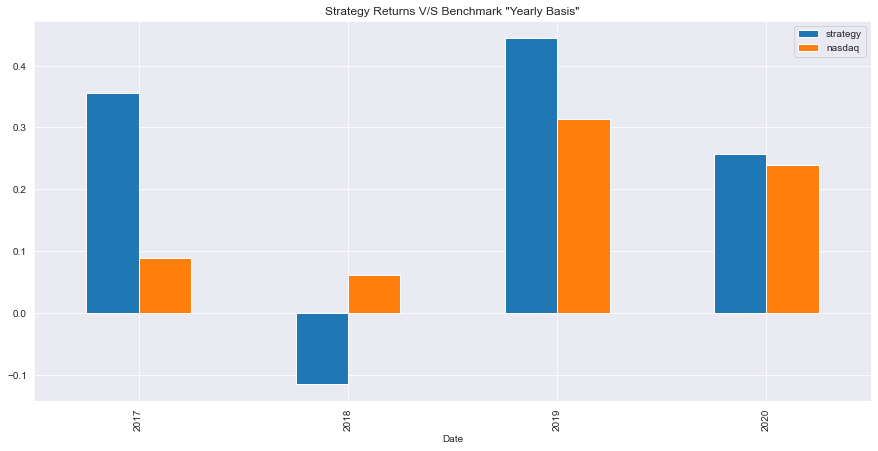

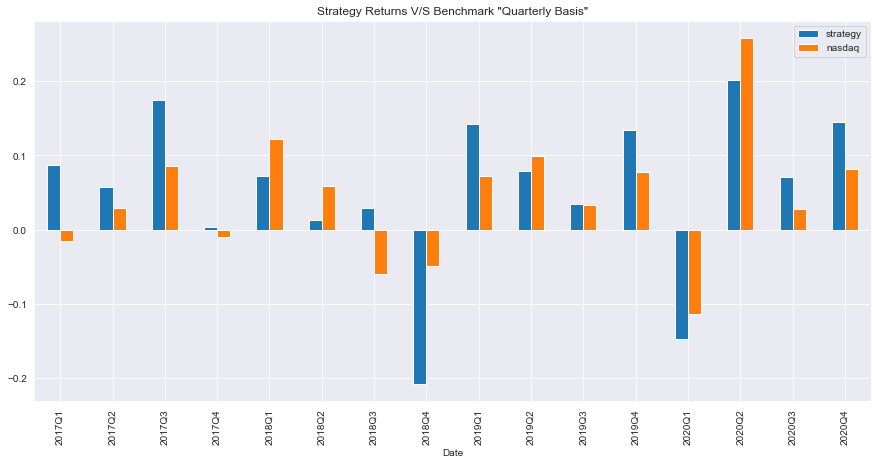

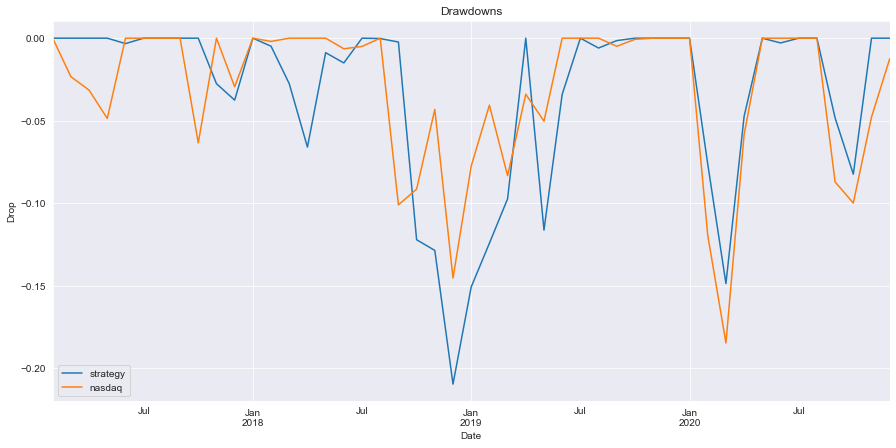

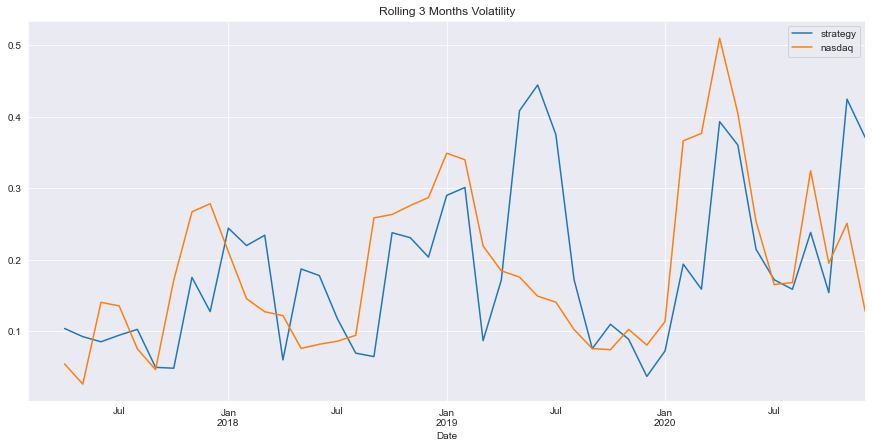

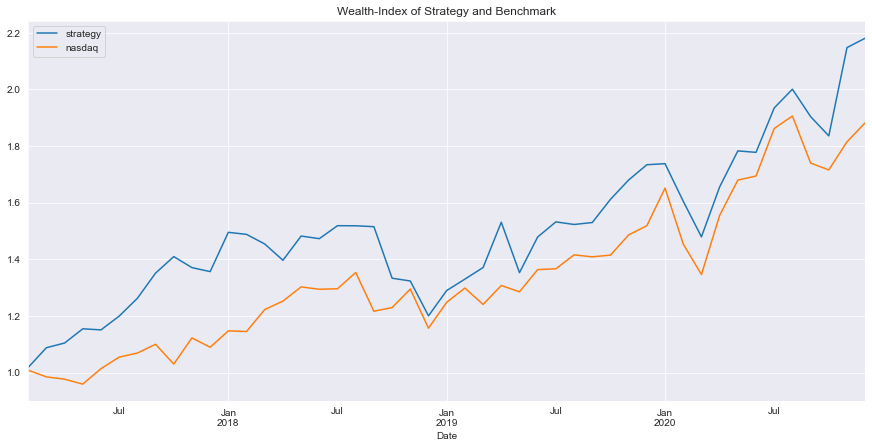

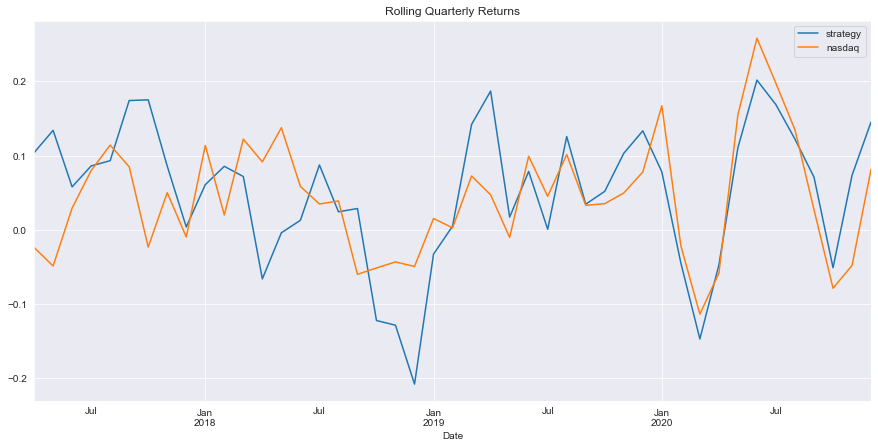

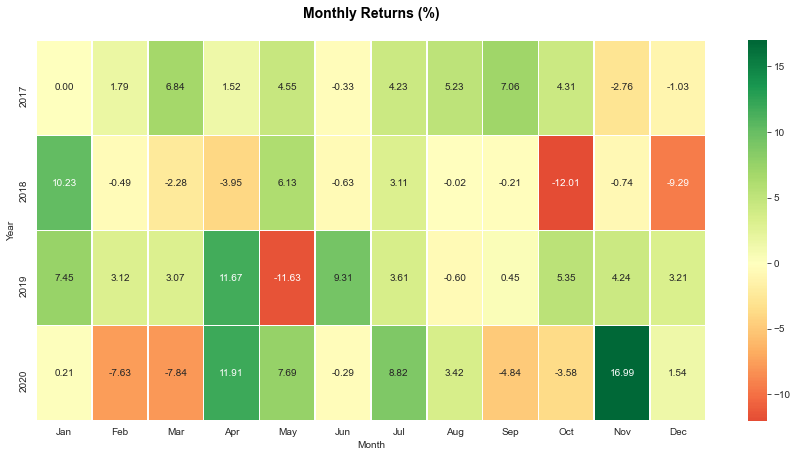

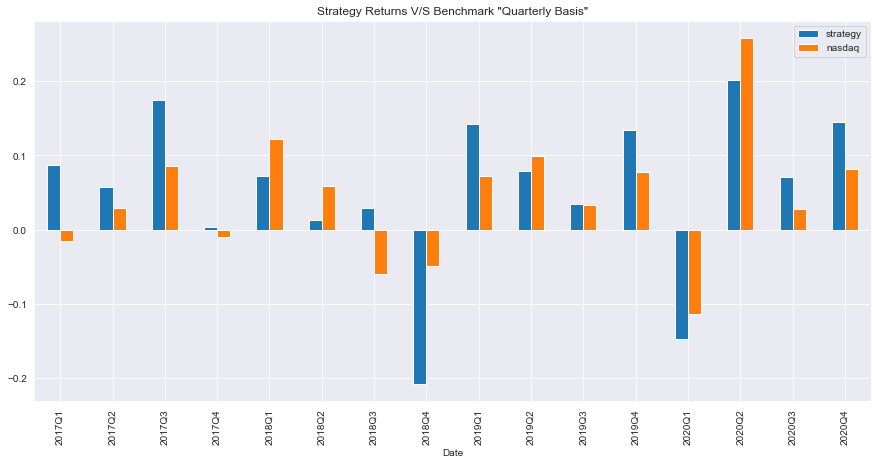

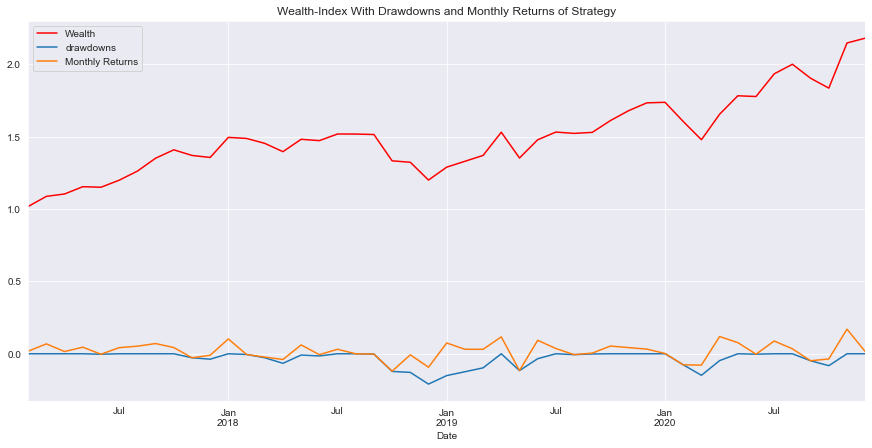

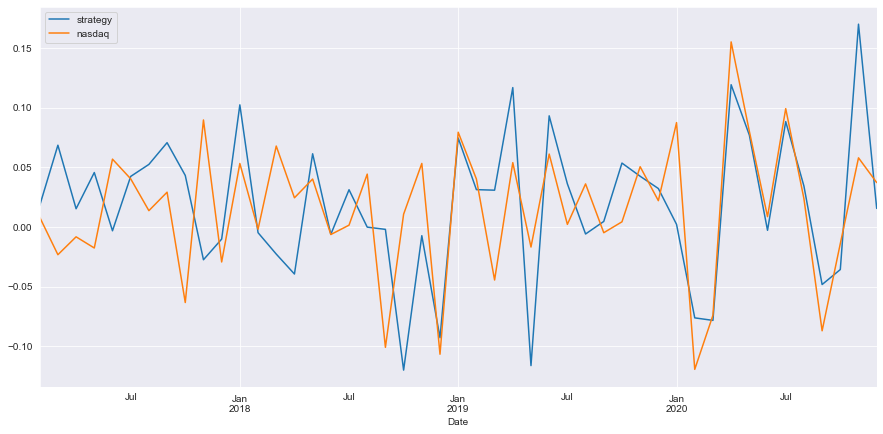

In [38]:
tear=ts.tear_sheet(frame_final,headline='Quantemantal Strategy')